# Hierarchical Modelling Introduction

This notebook uses [PyMC](https://www.pymc.io) to sample from a basic Hierarchical Bayesian Model (HBM).

Install PyMC by following the instructions here: https://www.pymc.io/projects/docs/en/latest/installation.html

This also requires the [corner](https://corner.readthedocs.io/en/latest/) package for plotting the posterior. Install with `pip install corner`.

In [2]:
!pip install pymc

ERROR: xarray 2023.1.0 has requirement packaging>=21.3, but you'll have packaging 20.4 which is incompatible.
ERROR: xarray 2023.1.0 has requirement pandas>=1.3, but you'll have pandas 1.0.5 which is incompatible.
ERROR: xarray-einstats 0.5.1 has requirement scipy>=1.6, but you'll have scipy 1.5.0 which is incompatible.
ERROR: arviz 0.15.1 has requirement pandas>=1.3.0, but you'll have pandas 1.0.5 which is incompatible.
ERROR: arviz 0.15.1 has requirement scipy>=1.8.0, but you'll have scipy 1.5.0 which is incompatible.
ERROR: arviz 0.15.1 has requirement setuptools>=60.0.0, but you'll have setuptools 49.2.0.post20200714 which is incompatible.
ERROR: arviz 0.15.1 has requirement typing-extensions>=4.1.0, but you'll have typing-extensions 3.7.4.2 which is incompatible.



  Using cached arviz-0.15.1-py3-none-any.whl (1.6 MB)
  Using cached xarray-2023.1.0-py3-none-any.whl (973 kB)
  Using cached h5netcdf-1.1.0-py2.py3-none-any.whl (26 kB)
  Using cached xarray_einstats-0.5.1-py3-none-any.whl (28 kB)
  Created wheel for miniKanren: filename=miniKanren-1.0.3-py3-none-any.whl size=23926 sha256=dfc43c4ad4a5b92804d5b60f1f15c9140d2b11257cef8e30db7e19d7c023e665
  Stored in directory: c:\users\georg\appdata\local\pip\cache\wheels\06\83\f0\bf4f50c0e6bfab8ae0860cb6e4a029a8a5346e3c1c38d926e6
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13926 sha256=9835481b02a702c67ded69493ab42764cbe4bbdfa0f92f114275a5df6ae40e5a
  Stored in directory: c:\users\georg\appdata\local\pip\cache\wheels\3a\ba\c0\41870a2550bb5c7f7d584882da204a2f570f3da7f939921b8a
  Created wheel for etuples: filename=etuples-0.3.9-py3-none-any.whl size=12642 sha256=0090f85a7bb11c490f31551677470197db7d85b381d998f11894dffc5a4b565a
  Stored in directory: 

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

from matplotlib import pyplot as plt
from matplotlib import rc
from corner import corner

C:\Users\georg\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## Example 1: Children's Birthday Party

You are a proffessional clown hosting a children's birthday party at the village hall. Billy Bayes is turning 10 years old and is inviting all 100 of his friends along. You don't know much about his friends but want to estimate the mean and standard deviation of their ages because you think it might impress them. You could just guess the ages of the children at the party, but the uncertainty on your guesses are about $\pm 1 yr$ which means you would observe an inflated spread of ages. You decide to use a hierarchical model to improve the age estimates by assuming an overall age distribution.

### Creating the Data

To test your method, you create a test sample with a mean age of 10 years and a standard deviation of 0.5 years such that the distribution of true ages $A_\text{true}$,

$A_\text{true} \sim \mathcal{N}(10.0, 0.5)$.

You know that you can guess ages with an uncertainty of 1 year, so the distribution of observed ages are,

$A_\text{obs} \sim \mathcal{N}(A_\text{true}, 1.0)$.

We may write this out below as:

In [22]:
age_billy_true = 10.0

In [21]:
rng = np.random.default_rng(seed=0)

n = 100  # Number of children at a party, not including Billy who we know is 10 years old.

# True ages
age_true_mu = # TODO
age_true_sigma = # TODO
age_true = rng.normal(size=n) * age_true_sigma + age_true_mu

# Observed ages
age_obs_sig = # 1.  # If this is too much larger than the true population spread it can break things!
age_obs = rng.normal(size=n) * age_obs_sig + age_true

SyntaxError: invalid syntax (1261522179.py, line 6)

Double-check the true and observed age distributions. We expect the observed distribution to be wider than the true distribution.

NameError: name 'age_obs' is not defined

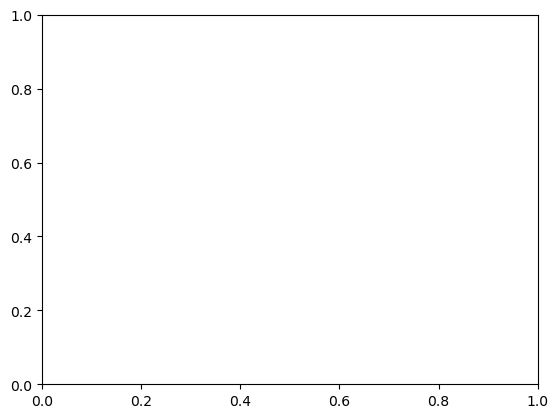

In [20]:
fig, ax = plt.subplots()
bins = 20
histtype = "step"
rlim = (age_obs.min(), age_obs.max())

ax.hist(age_true, bins=bins, histtype=histtype, range=rlim, label='Truth')
ax.hist(age_obs, bins=bins, histtype=histtype, range=rlim, label='Observed')
ax.set_xlabel("Age")
ax.legend();

In [5]:
age_true_mean = np.mean(age_true)
age_true_std = np.std(age_true)

print(f'true age mean = {age_true_mean}')
print(f'true age standard deviation = {age_true_std}')

true age mean = 10.040548346745357
true age standard deviation = 0.48106523056257156


### Creating a model

When creating a hierarchical model, we must choose appropriate priors for the mean and standard deviation. You can check the priors alone by commenting out `age` and `obs` below and then running the trace again. You may do this to check the affect of your prior on the posterior distributions for the mean and standard deviations. This example uses a weak prior, because the clown does not know much about Billy's friends. If, for example, you know that Billy only invited friends in the same year of school as himself, then you may confidently reduce the width of the prior.

The use of `age` is to introduce an unobserved "latent variable" to check consistancy. This is what sets the model a part from a typical Bayesian model.

Initially, let's assume we only measure ages for the first 10 people.

In [19]:
num_obs = 10

with pm.Model() as model:
    mu = pm.Normal('mu', mu= #something, sigma=5.0)
    sigma = pm.HalfNormal('sigma', sigma=5.0)
    
    # Sampling from a N(0, 1) distribution and rescaling is more stable
    # than sampling from N(mu, sigma)
    age = pm.Deterministic('age', mu + sigma * pm.Normal('age_scaled', shape=num_obs))

    obs = pm.Normal('obs', mu=age, sigma=age_obs_sig, observed=age_obs[:num_obs])

SyntaxError: '(' was never closed (639223625.py, line 4)

In [18]:
with model:
    trace = pm.sample()

NameError: name 'model' is not defined

In [17]:
trace

NameError: name 'trace' is not defined

Summarize the trace.

In [16]:
az.summary(trace)

NameError: name 'trace' is not defined

Let's look just at the population parameters.

In [15]:
az.summary(trace, var_names=['mu', 'sigma'])

NameError: name 'trace' is not defined

In [14]:
az.plot_trace(trace, var_names=['mu', 'sigma'])
plt.tight_layout()

NameError: name 'trace' is not defined

In [13]:
fig = corner(trace, var_names=["mu", "sigma"],
             truths={"mu": age_true_mean, "sigma": age_true_std})

NameError: name 'trace' is not defined

In [11]:
error = trace.posterior.age - age_true[:num_obs]

fig, ax = plt.subplots()
az.plot_density(error, combine_dims={"age_dim_0"}, ax=ax, colors="C1", hdi_prob=0.999);
ax.set_title("Age Error")
ax.set_xlabel("Age");

NameError: name 'trace' is not defined

Now we will add a very well-known data point, one might expect this to help. We give it a very small observed age.

In [14]:
num_obs = n  # observe all ages

with pm.Model() as model_all:
    # What should go here?

In [15]:
with model_all:
    trace_all = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, age_scaled]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [4]:
trace_all

NameError: name 'trace_all' is not defined

In [5]:
az.summary(trace_all)

NameError: name 'trace_all' is not defined

In [6]:
az.summary(trace_all, var_names=['mu', 'sigma'])

NameError: name 'trace_all' is not defined

In [7]:
az.plot_trace(trace_all, var_names=['mu', 'sigma'])
plt.tight_layout()

NameError: name 'trace_all' is not defined

In [8]:
fig = corner(trace_all, var_names=["mu", "sigma"],
             truths={"mu": age_true_mean, "sigma": age_true_std})

NameError: name 'trace_all' is not defined

See the improvement from more observations.

In [9]:
fig = corner(trace, var_names=["mu", "sigma"], color="C1")

fig = corner(trace_all, var_names=["mu", "sigma"], color="C2",
             truths={"mu": age_true_mean, "sigma": age_true_std}, fig=fig)

NameError: name 'trace' is not defined

In [10]:
error_all = trace_all.posterior.age - age_true

fig, ax = plt.subplots()
az.plot_density(error, combine_dims={"age_dim_0"}, ax=ax, colors="C1", hdi_prob=0.999);
az.plot_density(error_all, combine_dims={"age_dim_0"}, ax=ax, colors="C2", hdi_prob=0.999);

ax.set_title("Age Error")
ax.set_xlabel("Age");

NameError: name 'trace_all' is not defined